In [1]:
#imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import layers,models

#  1. Linear classifier for CIFAR10

In [98]:
#loading the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)
print('y_train:',y_train.shape)
print('x_test:',x_test.shape)
print('y_test:',y_test.shape)

K = len(np.unique(y_train)) #Classes
Ntr = x_train.shape[0]  #traning data
Nte = x_test.shape[0]   #testing data
Din = 3072 #CIFAR10
print('Classes K:',K)

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)
Classes K: 10


- np.unique - Returns the sorted unique elements of an array

In [99]:
#Normalize pixel values ( to have between 0 and 1)
x_train, x_test = x_train / 255.0, x_test / 255.0
#centering
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
#converts to catergorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)
#reshape inputs
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
#change data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train: ', x_train.shape)
print('y_train: ',y_train.shape)
print('x_test: ',x_test.shape)
print('y_test: ',y_test.shape)

x_train:  (50000, 3072)
y_train:  (50000, 10)
x_test:  (10000, 3072)
y_test:  (10000, 10)


- np.mean - Compute the arithmetic mean along the specified axis
- tf.keras.utils.to_categorical - converts a class vector (integers) to binary class matrix

### Definitions

In [9]:
#loss function
def Loss(y_pred,y,w1,w2=0):
    batch_size = y_pred.shape[0]
    loss = (1/batch_size)*(np.square(y-y_pred)).sum() + reg*(np.sum(w1*w1)+np.sum(w2*w2))
    return loss

In [10]:
#accuracy function
def Accuracy(y_pred,y):
    batch_size = y_pred.shape[0]
    K = y_pred.shape[1]
    acc = 1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [11]:
#linear classifier model
def LinearCls(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    std = 1e-5
    w1 = std*np.random.randn(Din, K)    #weight array
    b1 = np.zeros(K)    #bias array

    loss_history = []
    tst_loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        indices = np.arange(Ntr)
        rng.shuffle(indices)    #shuffle
        x = x_train[indices]
        y = y_train[indices]

        #forward pass
        y_pred = x.dot(w1)+b1
        y_pred_tst = x_test.dot(w1)+b1

            #losses
        train_loss = Loss(y_pred,y,w1)
        loss_history.append(train_loss)
        test_loss = Loss(y_pred_tst,y_test,w1)
        tst_loss_history.append(test_loss)
            #accuracies
        train_acc = Accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc = Accuracy(y_pred_tst,y_test)
        val_acc_history.append(test_acc)
            
        if t%10==0:
            print('iteration %d / %d: Train loss = %f , Test loss = %f , Train accuracy = %f , Test accuracy = %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred = (1./batch_size)*2.0*(y_pred-y)  #partial derivative of L w.r.t. y_pred
        dw1 = x.T.dot(dy_pred)+reg*w1
        db1 = dy_pred.sum(axis=0)
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,tst_loss_history,train_acc_history,val_acc_history

- np.random.randn - Return a sample (or samples) from the “standard normal” distribution
- np.random.default_rng - Construct a new Generator with the default BitGenerator (PCG64)
- np.arange - Return evenly spaced values within a given interval

In [12]:
#plotting losses and accuracies
def Plot(lst1,lst2=None,compare=False):
    fig, axes  = plt.subplots(1,4, figsize=(30,6))
    names = ['Train Loss','Test Loss','Train Accuracy','Test Accuracy']
    for i in range(len(names)):
        if compare:
            axes[i].plot(lst1[i])
            axes[i].plot(lst2[i])
            axes[i].legend(['Gradient descent','Stochastic gradient descent'])
        else:
            if i%2==0:
                axes[i].plot(lst1[i],color="r")
            else:
                axes[i].plot(lst1[i],color="b")
        if i==0 or i==1:
            axes[i].set_ylabel('Loss')
        else:
            axes[i].set_ylabel('Accuracy')
        axes[i].set_title(names[i])
        axes[i].set_xlabel('Epoch')

In [104]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda
w1,b1,loss_history,tst_loss_history,train_acc_history,val_acc_history = LinearCls(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

iteration 0 / 300: Train loss = 0.999983 , Test loss = 0.999980 , Train accuracy = 0.671632 , Test accuracy = 0.672490
iteration 10 / 300: Train loss = 0.876632 , Test loss = 0.876233 , Train accuracy = 0.756564 , Test accuracy = 0.758150
iteration 20 / 300: Train loss = 0.842537 , Test loss = 0.842415 , Train accuracy = 0.762576 , Test accuracy = 0.767890
iteration 30 / 300: Train loss = 0.823614 , Test loss = 0.823714 , Train accuracy = 0.766500 , Test accuracy = 0.770490
iteration 40 / 300: Train loss = 0.812387 , Test loss = 0.812706 , Train accuracy = 0.768576 , Test accuracy = 0.771510
iteration 50 / 300: Train loss = 0.805424 , Test loss = 0.805969 , Train accuracy = 0.770356 , Test accuracy = 0.772860
iteration 60 / 300: Train loss = 0.800904 , Test loss = 0.801678 , Train accuracy = 0.771562 , Test accuracy = 0.773400
iteration 70 / 300: Train loss = 0.797820 , Test loss = 0.798824 , Train accuracy = 0.772714 , Test accuracy = 0.773450
iteration 80 / 300: Train loss = 0.795604

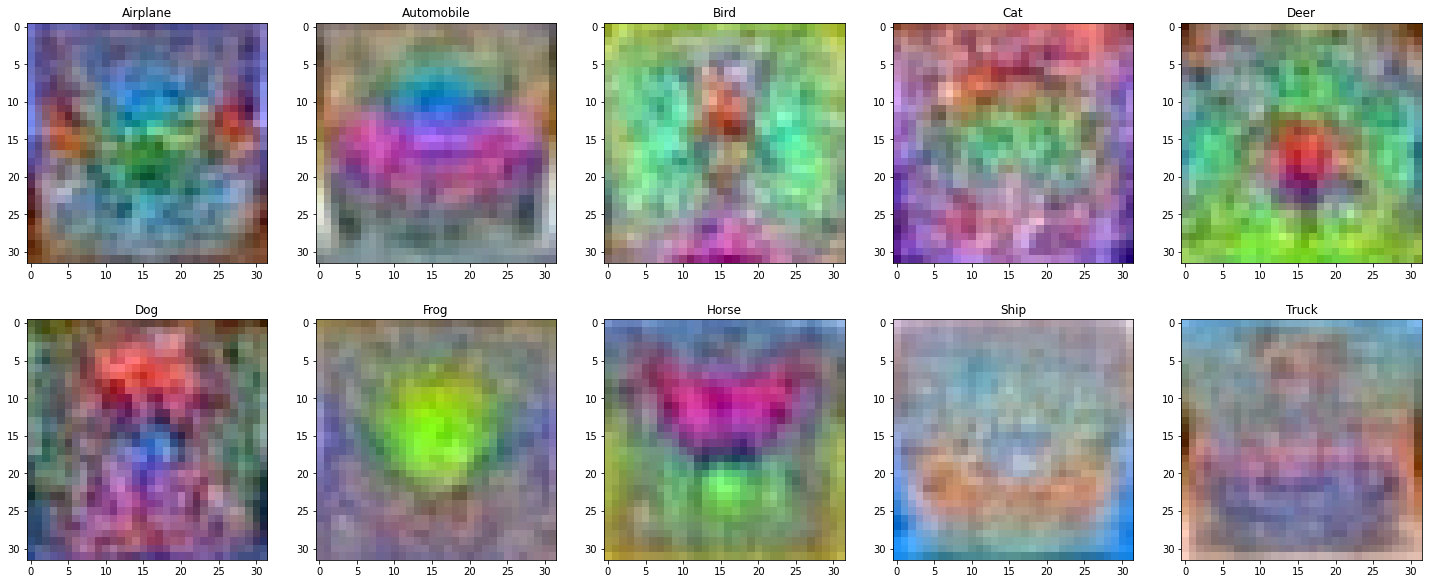

In [105]:
img = []
for i in range(w1.shape[1]):
    im = np.reshape(w1[:,i]*255,(32,32,3))
    im = cv.normalize(im, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)   #normalize the values
    img.append(im)
fig,ax = plt.subplots(2,5,figsize=(25,10))
class_names = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(img[i*5+j],vmin=0,vmax=255)
        ax[i,j].set_title(class_names[i*5+j])
plt.show()

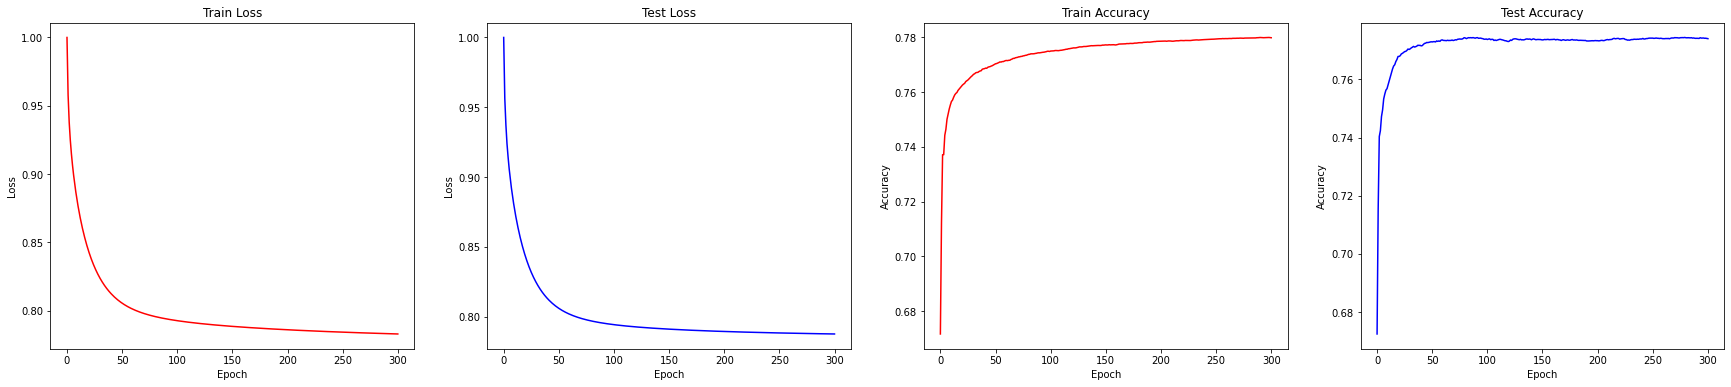

In [106]:
#plotting
lst1 = [loss_history,tst_loss_history,train_acc_history,val_acc_history]
Plot(lst1)

# 2. Two-layer fully connected network

In [21]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

K = len(np.unique(y_train)) # Classes
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10

In [22]:
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train: ', x_train.shape)
print('y_train: ',y_train.shape)
print('x_test: ',x_test.shape)
print('y_test: ',y_test.shape)

x_train:  (50000, 3072)
y_train:  (50000, 10)
x_test:  (10000, 3072)
y_test:  (10000, 10)


In [23]:
H = 200
stdN = 1e-6
w1N = stdN*np.random.randn(Din,H)
w2N = stdN*np.random.randn(H,K)
b1N = np.zeros(H)
b2N = np.zeros(K)
print("w1N:",w1N.shape)
print("w2N:",w2N.shape)
print("b1N:",b1N.shape)
print("b2N:",b2N.shape)

w1N: (3072, 200)
w2N: (200, 10)
b1N: (200,)
b2N: (10,)


In [24]:
def TwoLayer(x_train,y_train,x_test,y_test,K,Din,batch_size,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    H = 200
    stdN = 1e-5
    w1N = stdN*np.random.randn(Din,H)
    w2N = stdN*np.random.randn(H,K)
    b1N = np.zeros(H)
    b2N = np.zeros(K)

    loss_historyN = []
    tst_loss_historyN = []
    train_acc_historyN = []
    val_acc_historyN = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        indices = np.random.choice(Ntr,batch_size)
        
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]
        rng.shuffle(indices)
        x = x_train[indices]
        y = y_train[indices]
   
        #forward pass
        h = 1.0/(1.0 + np.exp(-(x.dot(w1N)+b1N)))   #sigmoid function for training set
        h_tst = 1.0/(1.0 + np.exp(-(x_test.dot(w1N)+b1N)))  #sigmoid function for test set
        y_predN = h.dot(w2N)+b2N
        y_pred_tstN = h_tst.dot(w2N)+b2N

        train_lossN = Loss(y_predN,y,w1N,w2N)
        loss_historyN.append(train_lossN)
        test_lossN = Loss(y_pred_tstN,y_test,w1N,w2N)
        tst_loss_historyN.append(test_lossN)
        train_accN = Accuracy(y_predN,y)
        train_acc_historyN.append(train_accN)
        test_accN = Accuracy(y_pred_tstN,y_test)
        val_acc_historyN.append(test_accN)

        if t%10==0:
            print('iteration %d / %d: Train loss = %f , Test loss = %f , Train accuracy = %f , Test accuracy = %f' % (t,iterations,train_lossN,test_lossN,train_accN,test_accN))

        # Backward pass
        dy_predN = (1./batch_size)*2.0*(y_predN-y)  #partial derivative of L w.r.t. y_pred
        dw2N = h.T.dot(dy_predN)+reg*w2N
        db2N = dy_predN.sum(axis=0)
        dh = dy_predN.dot(w2N.T)
        dw1N = x.T.dot(dh*h*(1-h))+reg*w1N
        db1N = (dh*h*(1-h)).sum(axis=0)
        w1N-=lr*dw1N
        b1N-=lr*db1N
        w2N-=lr*dw2N
        b2N-=lr*db2N
        lr*=lr_decay
    return w1N,b1N,w2N,b2N,loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN

- np.random.choice - Generates a random sample from a given 1-D array

In [25]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda
w1N,b1N,w2N,b2N,loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN = TwoLayer(x_train,y_train,x_test,y_test,K,Din,batch_size,lr,lr_decay,reg)

iteration 0 / 300: Train loss = 1.000032 , Test loss = 1.000032 , Train accuracy = 0.646306 , Test accuracy = 0.644980
iteration 10 / 300: Train loss = 0.876167 , Test loss = 0.875595 , Train accuracy = 0.712446 , Test accuracy = 0.716260
iteration 20 / 300: Train loss = 0.842770 , Test loss = 0.842056 , Train accuracy = 0.724200 , Test accuracy = 0.725090
iteration 30 / 300: Train loss = 0.831027 , Test loss = 0.830638 , Train accuracy = 0.733348 , Test accuracy = 0.733020
iteration 40 / 300: Train loss = 0.819017 , Test loss = 0.819364 , Train accuracy = 0.748662 , Test accuracy = 0.747760
iteration 50 / 300: Train loss = 0.812759 , Test loss = 0.812742 , Train accuracy = 0.752896 , Test accuracy = 0.755380
iteration 60 / 300: Train loss = 0.804877 , Test loss = 0.805300 , Train accuracy = 0.760728 , Test accuracy = 0.766080
iteration 70 / 300: Train loss = 0.797605 , Test loss = 0.798106 , Train accuracy = 0.767184 , Test accuracy = 0.766540
iteration 80 / 300: Train loss = 0.796228

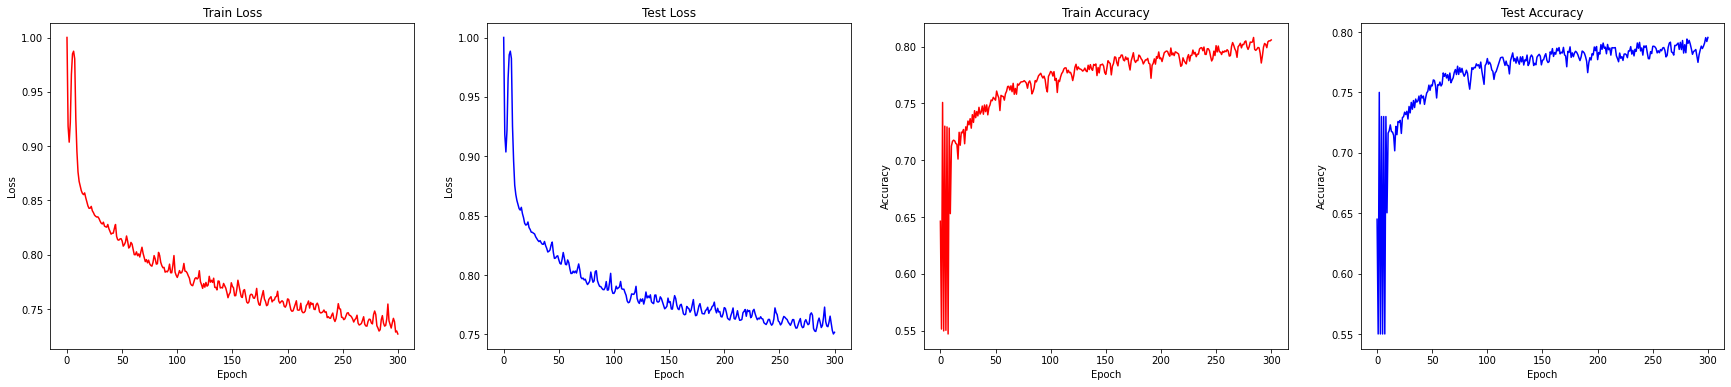

In [26]:
#plotting
lst1 = [loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN]
Plot(lst1)

# 3. Stochastic gradient descent

In [27]:
def TwoLayer_sgd(x_train,y_train,x_test,y_test,K,Din,batch_size,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    H = 200
    stdN = 1e-5
    w1N = stdN*np.random.randn(Din,H)
    w2N = stdN*np.random.randn(H,K)
    b1N = np.zeros(H)
    b2N = np.zeros(K)

    loss_historyN = []
    tst_loss_historyN = []
    train_acc_historyN = []
    val_acc_historyN = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        ind = np.random.choice(Ntr,Ntr)
        rng.shuffle(ind)
        #run a group of batch for each epoch
        for btch in range(int(Ntr/batch_size)):
            grp = ind[btch*batch_size:batch_size*(btch+1)]
            x = x_train[grp]
            y = y_train[grp]
            #forward pass
            h = 1/(1 + np.exp(-(x.dot(w1N)+b1N)))   #sigmoid function for training set
            y_predN = h.dot(w2N)+b2N
            # Backward pass
            dy_predN = (1./batch_size)*2.0*(y_predN-y)  #partial derivative of L w.r.t. y_pred
            dw2N = h.T.dot(dy_predN)+reg*w2N
            db2N = dy_predN.sum(axis=0)
            dh = dy_predN.dot(w2N.T)
            dw1N = x.T.dot(dh*h*(1-h))+reg*w1N
            db1N = (dh*h*(1-h)).sum(axis=0)
            w1N-=lr*dw1N
            b1N-=lr*db1N
            w2N-=lr*dw2N
            b2N-=lr*db2N
            lr*=lr_decay
        
        #forward pass
        h_tst = 1.0/(1.0 + np.exp(-(x_test.dot(w1N)+b1N)))  #sigmoid function for test set
        y_pred_tstN = h_tst.dot(w2N)+b2N

        train_lossN = Loss(y_predN,y,w1N,w2N)
        loss_historyN.append(train_lossN)
        test_lossN = Loss(y_pred_tstN,y_test,w1N,w2N)
        tst_loss_historyN.append(test_lossN)
        train_accN = Accuracy(y_predN,y)
        train_acc_historyN.append(train_accN)
        test_accN = Accuracy(y_pred_tstN,y_test)
        val_acc_historyN.append(test_accN)

        if t%10==0:
            print('iteration %d / %d: Train loss = %f , Test loss = %f , Train accuracy = %f , Test accuracy = %f' % (t,iterations,train_lossN,test_lossN,train_accN,test_accN))

        
    return w1N,b1N,w2N,b2N,loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN

In [28]:
iterations = 300
batch_size = 500
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda
w1Ns,b1Ns,w2Ns,b2Ns,loss_historyNs,tst_loss_historyNs,train_acc_historyNs,val_acc_historyNs = TwoLayer_sgd(x_train,y_train,x_test,y_test,K,Din,batch_size,lr,lr_decay,reg)

iteration 0 / 300: Train loss = 0.794791 , Test loss = 0.797960 , Train accuracy = 0.765400 , Test accuracy = 0.766950
iteration 10 / 300: Train loss = 0.667912 , Test loss = 0.739727 , Train accuracy = 0.857400 , Test accuracy = 0.797280
iteration 20 / 300: Train loss = 0.628593 , Test loss = 0.736262 , Train accuracy = 0.869800 , Test accuracy = 0.800760
iteration 30 / 300: Train loss = 0.627555 , Test loss = 0.738894 , Train accuracy = 0.857600 , Test accuracy = 0.800660
iteration 40 / 300: Train loss = 0.600798 , Test loss = 0.739636 , Train accuracy = 0.875600 , Test accuracy = 0.801140
iteration 50 / 300: Train loss = 0.578325 , Test loss = 0.739844 , Train accuracy = 0.894600 , Test accuracy = 0.801580
iteration 60 / 300: Train loss = 0.579096 , Test loss = 0.740068 , Train accuracy = 0.885200 , Test accuracy = 0.801410
iteration 70 / 300: Train loss = 0.598540 , Test loss = 0.740118 , Train accuracy = 0.888800 , Test accuracy = 0.801920
iteration 80 / 300: Train loss = 0.585749

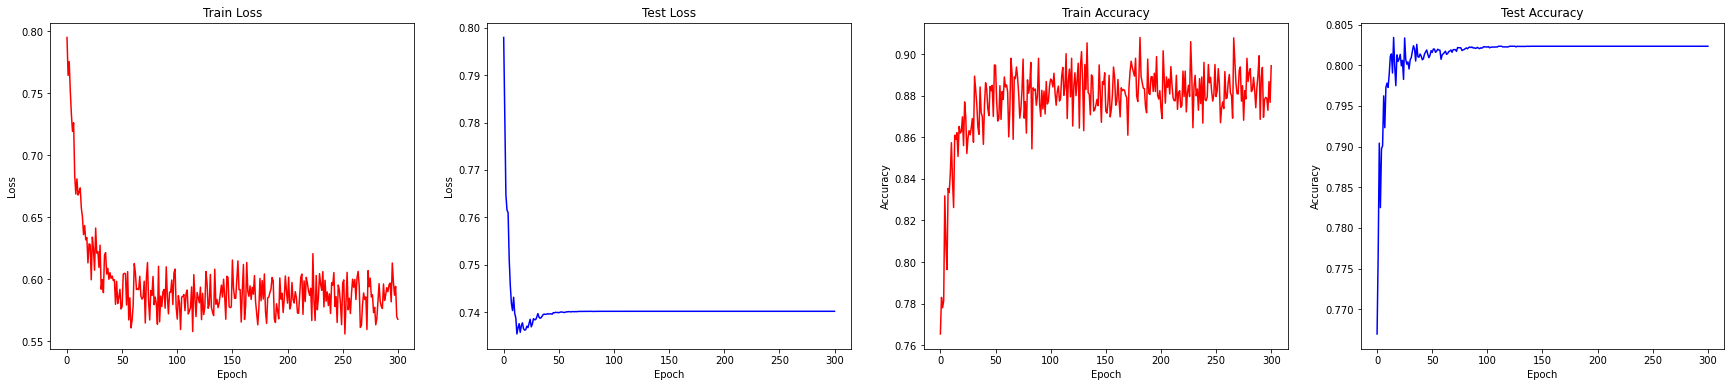

In [29]:
#plotting
lst1 = [loss_historyNs,tst_loss_historyNs,train_acc_historyNs,val_acc_historyNs]
Plot(lst1)

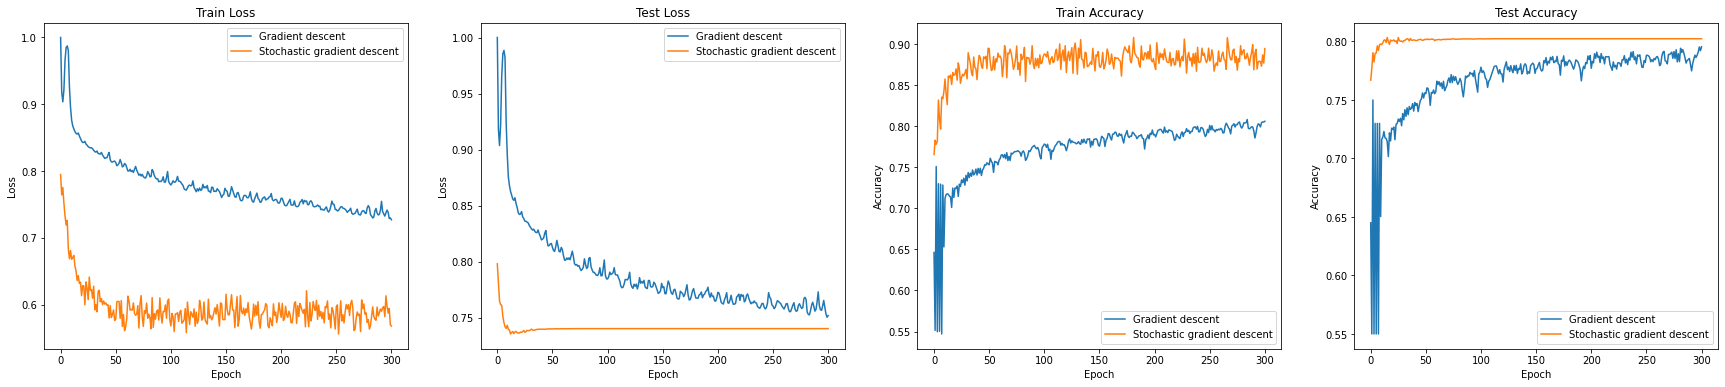

In [30]:
#compare
lst1 = [loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN]
lst2 = [loss_historyNs,tst_loss_historyNs,train_acc_historyNs,val_acc_historyNs]
Plot(lst1,lst2,compare=True)

# 4. CNN

In [22]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
#normalized
x_train, x_test = x_train / 255.0, x_test / 255.0
#centralized
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
#converts to catergorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

print(model.summary())

optmz = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name="SGD")
model.compile(optimizer=optmz,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history = model.fit(x_train,y_train,epochs=60,batch_size=50,validation_data=(x_test,y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

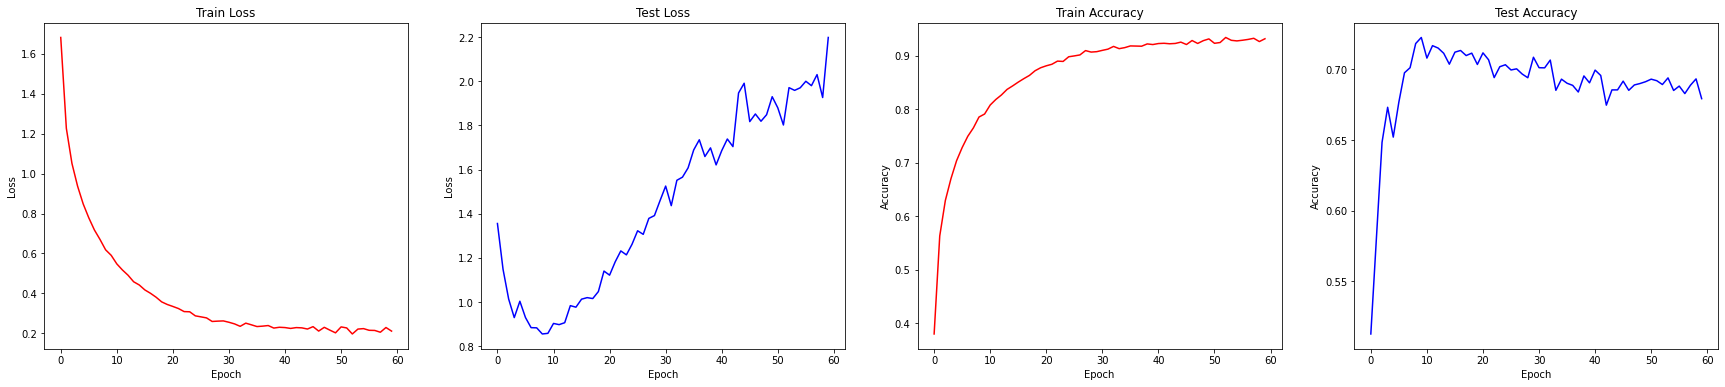

In [23]:
#plotting
lst1 = [history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy']]
Plot(lst1)

In [24]:
train_loss, train_acc = model.evaluate(x_train,y_train,verbose=2)
print('Train Loss:',train_loss)
print('Train Accuracy:',train_acc)

test_loss, test_acc = model.evaluate(x_test,y_test,verbose=2)
print('Test Loss:',test_loss)
print('Test Accuracy:',test_acc)

1563/1563 - 15s - loss: 0.1836 - accuracy: 0.9378
Train Loss: 0.183608278632164
Train Accuracy: 0.9377800226211548
313/313 - 3s - loss: 2.1984 - accuracy: 0.6793
Test Loss: 2.1983673572540283
Test Accuracy: 0.6793000102043152
